Hotspot Detection with XGBoost

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df=pd.read_excel('2020-2025-education-in-danger-incident-data.xlsx')
df.head()

,Date,Event Description,Country,Country ISO,Admin 1,Latitude,Longitude,Geo Precision,Location of event,Reported Perpetrator,...,Educators Arrested,Known Educators Kidnap Or Arrest Outcome,Students Attacked in School,Students Killed,Students Injured,Students Kidnapped,Known Student Kidnap Or Arrest Outcome,Students Arrested,Sexual Violence Affecting School Age Children,SiND Event ID
0,2025-05-25,NaN,Ukraine,UKR,Chernihiv Oblast,51.4,31.2,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100323
1,2025-05-24,NaN,Ukraine,UKR,Obolonskyi district,50.5,30.5,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100318
2,2025-05-24,NaN,Ukraine,UKR,Dniprovskyi district,50.4,30.5,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100317
3,2025-05-22,NaN,Ukraine,UKR,Donetsk Oblast,48.5,37.6,(2) 25 km Precision,Education Building,Other,...,0,NaN,0,0,0,0,NaN,0,0,100315
4,2025-05-12,NaN,Ukraine,UKR,Sumy Oblast,50.9,34.2,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,99014


In [3]:
df.isnull().sum()

Date                                                0
Event Description                                4607
Country                                             0
Country ISO                                         0
Admin 1                                             4
Latitude                                          626
Longitude                                         626
Geo Precision                                       1
Location of event                                   4
Reported Perpetrator                                0
Reported Perpetrator Name                           0
Weapon Carried/Used                                 0
Type of education facility                          0
Attacks on Schools                                  0
Attacks on Universities                             0
Military Occupation of Education facility           0
Arson attack on education facility                  0
Forced Entry into education facility                0
Damage/Destruction To Ed fac

In [4]:
# 2. Numerical columns ke liye missing values fill (mean/median)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# 3. Categorical columns ke liye missing values fill (mode)
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 4. Agar kuch irrelevant columns ho jisme bahut zyada missing hai (>50%), to unhe drop karo
threshold = 0.5  # 50%
df = df.dropna(thresh=len(df) * threshold, axis=1)

print("Missing values handled successfully!")


Missing values handled successfully!


In [5]:
#to check if any missing values remain
print("Remaining missing values per column:\n", df.isnull().sum())

Remaining missing values per column:
 Date                                             0
Country                                          0
Country ISO                                      0
Admin 1                                          0
Latitude                                         0
Longitude                                        0
Geo Precision                                    0
Location of event                                0
Reported Perpetrator                             0
Reported Perpetrator Name                        0
Weapon Carried/Used                              0
Type of education facility                       0
Attacks on Schools                               0
Attacks on Universities                          0
Military Occupation of Education facility        0
Arson attack on education facility               0
Forced Entry into education facility             0
Damage/Destruction To Ed facility Event          0
Attacks on Students and Teachers            

In [6]:
#Create Total_Attacks
df["Total_Attacks"] = (
    df["Attacks on Schools"] +
    df["Attacks on Universities"] +
    df["Military Occupation of Education facility"] +
    df["Arson attack on education facility"] +
    df["Attacks on Students and Teachers"]
)

In [7]:
# Create Binary Target (Hotspot = 1 if attacks > median)
threshold = df["Total_Attacks"].median()
df["Hotspot"] = (df["Total_Attacks"] > threshold).astype(int)

In [8]:
#Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [9]:
#Define X and y
X = df.drop(columns=["Hotspot"])   # features
y = df["Hotspot"]                 # target

In [10]:
# Handle datetime columns
datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    # Extract useful datetime features
    X[f'{col}_year'] = X[col].dt.year
    X[f'{col}_month'] = X[col].dt.month
    X[f'{col}_day'] = X[col].dt.day
    # Drop original datetime column
    X = X.drop(columns=[col])

# Convert remaining features to appropriate types
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')
    elif X[col].dtype not in ['int64', 'float64']:
        X[col] = X[col].astype('float64')

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Verify the split
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Train XGBoost Classifier (your existing code)
xgb_clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    enable_categorical=True
)
xgb_clf.fit(X_train, y_train)

Training set shape: (3685, 35)
Testing set shape: (922, 35)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [12]:
#verify data types after conversion
print("Feature datatypes after conversion:")
print(X.dtypes)

Feature datatypes after conversion:
Country                                            int64
Country ISO                                        int64
Admin 1                                            int64
Latitude                                         float64
Longitude                                        float64
Geo Precision                                      int64
Location of event                                  int64
Reported Perpetrator                               int64
Reported Perpetrator Name                          int64
Weapon Carried/Used                                int64
Type of education facility                         int64
Attacks on Schools                                 int64
Attacks on Universities                            int64
Military Occupation of Education facility          int64
Arson attack on education facility                 int64
Forced Entry into education facility               int64
Damage/Destruction To Ed facility Event            i

In [13]:
#Predictions
y_pred = xgb_clf.predict(X_test)

In [14]:
#Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       603
           1       1.00      1.00      1.00       319

    accuracy                           1.00       922
   macro avg       1.00      1.00      1.00       922
weighted avg       1.00      1.00      1.00       922

Confusion Matrix:
 [[603   0]
 [  0 319]]


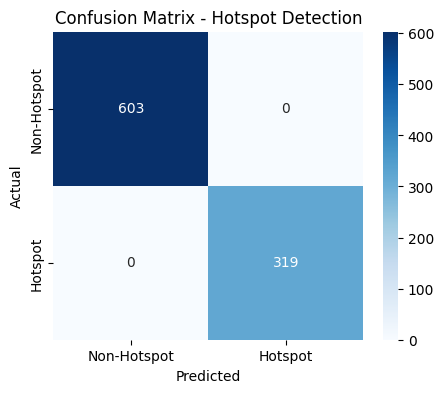

In [15]:
#Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", xticklabels=["Non-Hotspot","Hotspot"], yticklabels=["Non-Hotspot","Hotspot"])
plt.title("Confusion Matrix - Hotspot Detection")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

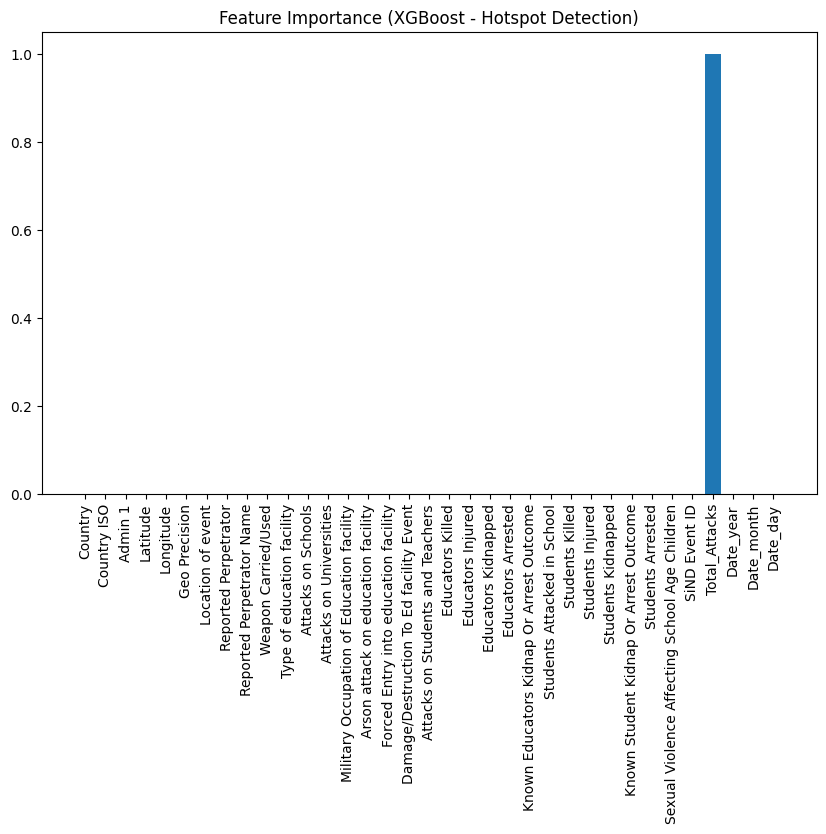

In [16]:
#Feature Importance
plt.figure(figsize=(10,6))
plt.bar(X.columns, xgb_clf.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importance (XGBoost - Hotspot Detection)")
plt.show()

In [17]:
# Example: real (actual) labels and predicted labels
# (0 = Non-Hotspot, 1 = Hotspot)
y_test = [0, 1, 0, 1, 1, 0, 1, 0, 1, 1]       # actual labels
y_pred = [0, 1, 0, 0, 1, 0, 1, 0, 1, 1]       # predicted labels

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Detailed report (Precision, Recall, F1)
report = classification_report(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("📊 Hotspot Detection Model Evaluation:")
print(f"Accuracy : {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", cm)

📊 Hotspot Detection Model Evaluation:
Accuracy : 0.90

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.83      0.91         6

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10

Confusion Matrix:
 [[4 0]
 [1 5]]


In [18]:
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the trained model (not the notebook) with .joblib extension
from joblib import dump, load
model_path = os.path.join('models', 'timeseries_model.joblib')

# Save the trained model instance
with open(model_path, 'wb') as f:
    dump(xgb_clf, f)  # Use 'model' instead of 'TimeSeries'
    print(f"Model saved successfully to {model_path}")

Model saved successfully to models\timeseries_model.joblib
